In [1]:
# which attack level to add noise
noise_type = 7
# how much noise to add: 0.00, 0.05, 0.10, 0.20, 0.50
noise_percent = 0.50

In [2]:
import re
import os
import random
import numpy as np
from tqdm import tqdm
from scipy.io import loadmat
import matplotlib.pyplot as plt

import torch
from torchinfo import summary
from torch.utils.data import DataLoader

from models.ae_trainer import AETrainer

In [3]:
DATASET_PATH = os.path.join(os.getcwd(), 'data')

In [4]:
seed = 41
torch.manual_seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class SensorDataset():
    def __init__(self, data: np.array):
        self.x = self.np2tensor(data)
        
    @staticmethod
    def np2tensor(x):
        return torch.tensor(x, dtype=torch.float32)
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx]

In [6]:
latent_dims = 118
batch_size = 16
epochs = 1000

In [7]:
data_filename = 'data.mat'
data = loadmat(os.path.join(DATASET_PATH, data_filename))
Z = data['Z']
T = len(Z)
train_size = int(T * 0.8)
lr = 1e-1
scheduler = True
es_patience = 10

In [8]:
# read attack noise
NOISE_PATH = os.path.join(DATASET_PATH, f'I{noise_type}')
Z_noise = dict()
for filename in tqdm(os.listdir(NOISE_PATH), desc='Reading noise data ... '):
    fname = os.path.join(NOISE_PATH, filename)
    data = loadmat(fname)
    att_type = int(re.findall(r'\d+', filename)[0])
    Z_noise[att_type] = np.array(data['Z'])

Z_noise = dict(sorted(Z_noise.items()))

Reading noise data ... : 100%|██████████| 3/3 [00:00<00:00,  6.87it/s]


In [9]:
noise_size = int(T * noise_percent)
norm_operation_win = 50
# sample random times after norm_operation_win to add in Z
noise_time = np.random.choice(list(range(norm_operation_win, T)), size=noise_size, replace=False)
# sample attack types to sample a noise
noise_to_add_from = np.random.choice(list(Z_noise.keys()), size=noise_size, replace=True).tolist()
random.shuffle(noise_to_add_from)
# randomly select noises from attack types
noises = []
for _type in noise_to_add_from:
    noise_id = random.sample(range(T), 1)
    noises.append(Z_noise[_type][noise_id])
random.shuffle(noises)
if len(noises) > 0:
    noises = np.concatenate(noises, axis=0)
    # add noises to original sensor data Z
    Z[noise_time,:] = noises


In [10]:
Z_train, Z_test = Z[:train_size], Z[train_size:]
training = SensorDataset(Z_train)
test = SensorDataset(Z_test)
train_dl = DataLoader(training, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test)

In [11]:
trainer = AETrainer(latent_dim=latent_dims, lr=lr, 
                    lr_scheduler=scheduler, es_patience=es_patience,
                    checkpoint_name=f'ae_{int(noise_percent * 100)}%.pt', 
                    seed=seed)

In [12]:
summary(trainer.ae, (1, 358))

Layer (type:depth-idx)                   Output Shape              Param #
AE                                       [1, 358]                  --
├─Encoder: 1-1                           [1, 118]                  --
│    └─Linear: 2-1                       [1, 236]                  84,724
│    └─BatchNorm1d: 2-2                  [1, 236]                  472
│    └─Linear: 2-3                       [1, 118]                  27,966
├─Decoder: 1-2                           [1, 358]                  --
│    └─Linear: 2-4                       [1, 236]                  28,084
│    └─BatchNorm1d: 2-5                  [1, 236]                  472
│    └─Linear: 2-6                       [1, 358]                  84,846
Total params: 226,564
Trainable params: 226,564
Non-trainable params: 0
Total mult-adds (M): 0.23
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.91
Estimated Total Size (MB): 0.92

In [13]:
ae, mse, val_mse = trainer.train(train_dl, test_dl, epochs=epochs)

Epoch 1/1000: [MSE: 1.2522], [Val_MSE: 0.0710], 
Validation loss decreased (inf --> 0.070958).  Saving model ...
Epoch 2/1000: [MSE: 0.0769], [Val_MSE: 0.0657], 
Validation loss decreased (0.070958 --> 0.065692).  Saving model ...
Epoch 3/1000: [MSE: 0.0703], [Val_MSE: 0.0536], 
Validation loss decreased (0.065692 --> 0.053643).  Saving model ...
Epoch 4/1000: [MSE: 0.0652], [Val_MSE: 0.0525], 
Validation loss decreased (0.053643 --> 0.052541).  Saving model ...
Epoch 5/1000: [MSE: 0.0566], [Val_MSE: 0.0592], 
EarlyStopping counter: 1 out of 10
Epoch 6/1000: [MSE: 0.0501], [Val_MSE: 0.0518], 
Validation loss decreased (0.052541 --> 0.051759).  Saving model ...
Epoch 7/1000: [MSE: 0.0501], [Val_MSE: 0.0406], 
Validation loss decreased (0.051759 --> 0.040556).  Saving model ...
Epoch 8/1000: [MSE: 0.0504], [Val_MSE: 0.0330], 
Validation loss decreased (0.040556 --> 0.032990).  Saving model ...
Epoch 9/1000: [MSE: 0.0489], [Val_MSE: 0.0305], 
Validation loss decreased (0.032990 --> 0.0305

In [14]:
def plot_learning(mse, val_mse):
    fig, axs = plt.subplots(1, figsize=(6,4))
    axs.plot(mse, color='r', label='Training')
    axs.plot(val_mse, color='b', label='Validation')
    axs.set_title('MSE Loss')
    plt.legend()
    #plt.savefig('./imgMix/mse-kl-mvae.pdf', format='pdf', dpi=1200)
    plt.show()

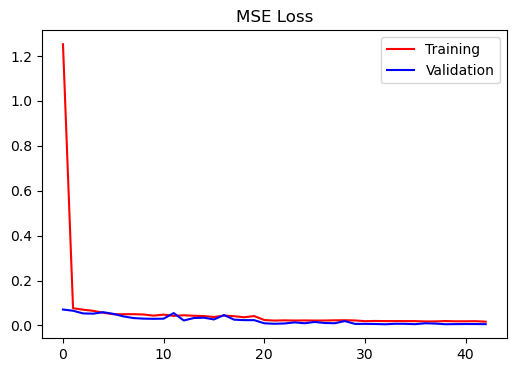

In [15]:
plot_learning(mse, val_mse)

In [16]:
ae.eval()
Z = torch.tensor(Z, dtype=torch.float32).to(device)
Z_enc = ae(Z)

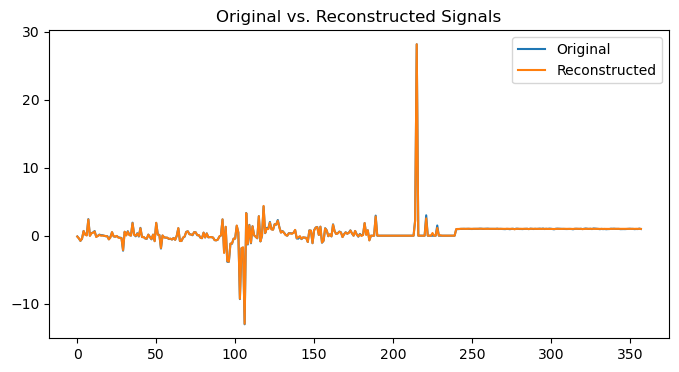

In [17]:
idx = 876
fig, axs = plt.subplots(figsize=(8,4))
axs.plot(np.transpose(Z[idx,:].cpu().detach().numpy()), label='Original')
axs.plot(np.transpose(Z_enc[idx,:].cpu().detach().numpy()), label='Reconstructed')
axs.set_title('Original vs. Reconstructed Signals')
plt.legend()
plt.show()

In [18]:
ae.eval()
Z_latent = ae.encoder(Z)

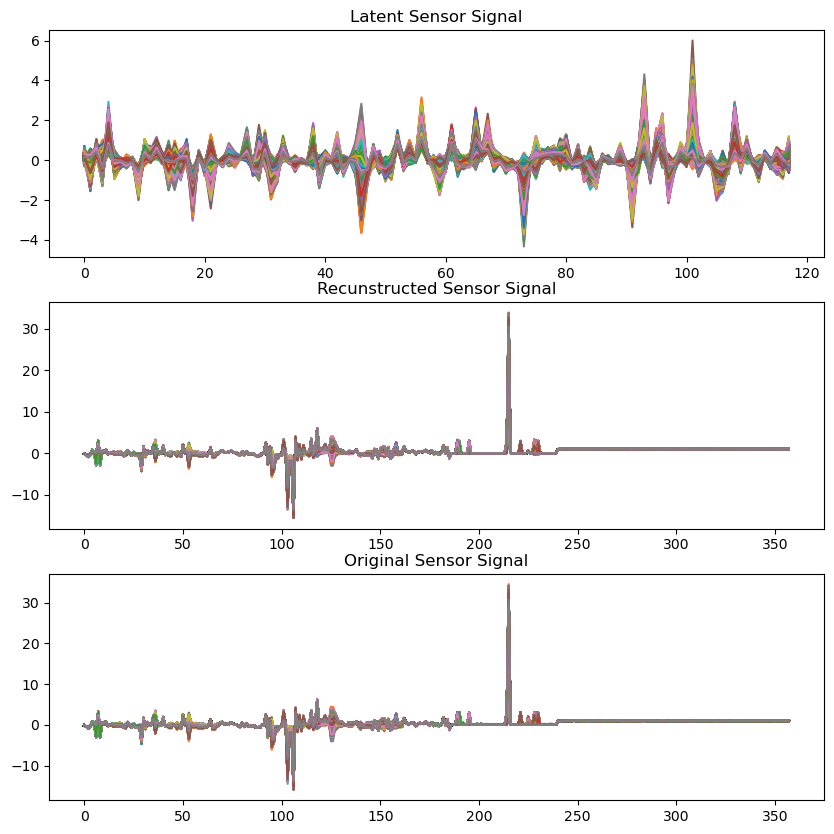

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(10,10))
axs[0].plot(np.transpose(Z_latent.cpu().detach().numpy()))
axs[0].set_title('Latent Sensor Signal')
axs[1].plot(np.transpose(Z_enc.cpu().detach().numpy()))
axs[1].set_title('Recunstructed Sensor Signal')
axs[2].plot(np.transpose(Z.cpu().detach().numpy()))
axs[2].set_title('Original Sensor Signal')
plt.show()